In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS,LSTM, NHITS, RNN
from sklearn.preprocessing import Normalizer,QuantileTransformer,StandardScaler,MinMaxScaler
# Disable logging messages unless there is an error
import warnings
warnings.filterwarnings('ignore')

def plot_df(df):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Check if the DataFrame 'dfs' is empty
    if df.empty:
        print("Error: DataFrame is empty.")
        # Handle the error as desired, e.g., raise an exception or return an error message

    # Plot the data
    ax.plot(df["ds"], df["y"])

    # Add labels and title
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.set_title("Data Plot")

    # Display the plot
    plt.show()

# Load the dataset
df = pd.read_csv("history_processed.csv", parse_dates=["ds"])
df['unique_id'] = '1D'
df = df[df['ds']>='2018-01-01']
df.head()

NameError: name 'set_log_level' is not defined

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2055 entries, 1829 to 3883
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         2055 non-null   datetime64[ns]
 1   y          2055 non-null   float64       
 2   unique_id  2055 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 64.2+ KB


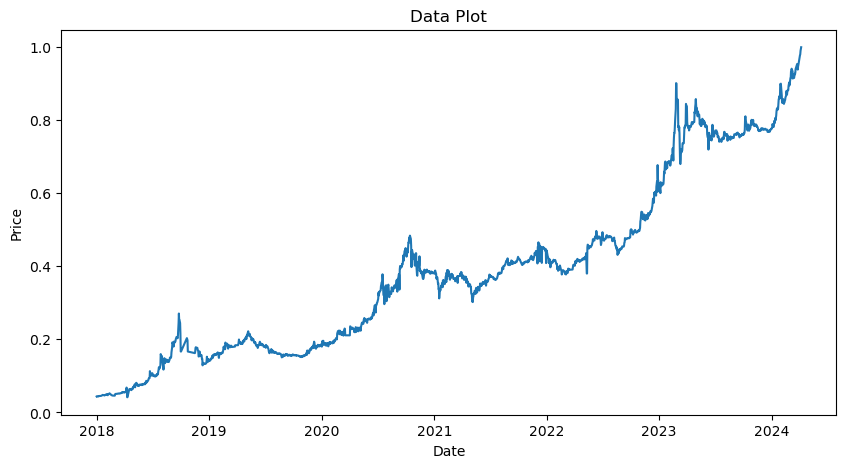

In [38]:
plot_df(df)

In [39]:
Y_train_df = df[df.ds<='2023-12-31'] 
Y_test_df = df[df.ds>'2023-12-31'] 
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=100),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=100),
          LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1])]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()



Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

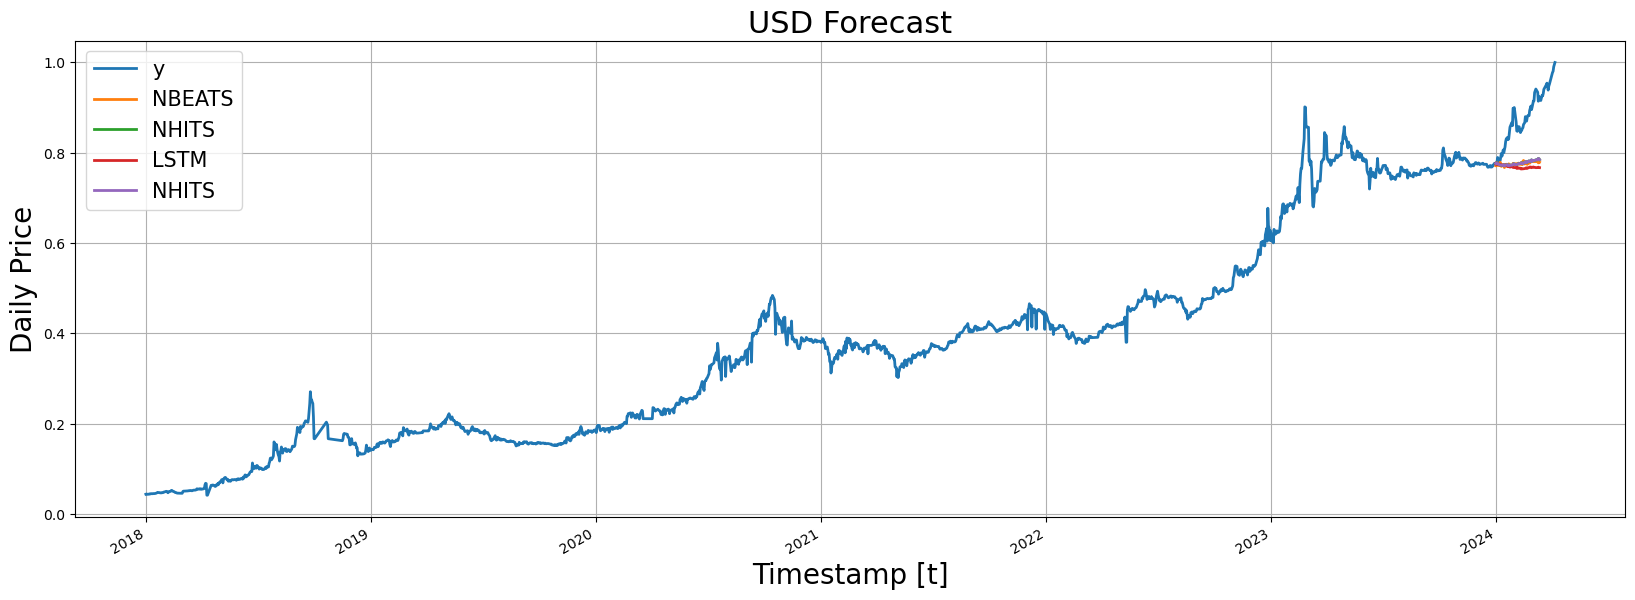

In [40]:
# Plot predictions
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7)) # Create a figure and axes object

Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds']) # Merge predicted and actual values by unique_id and ds

plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds') # Concatenate training and predicted values by 'ds' index

plot_df[['y', 'NBEATS', 'NHITS', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2) # Plot actual and predicted values with different colors and linewidth

ax.set_title('USD Forecast', fontsize=22) # Set the title of the plot
ax.set_ylabel('Daily Price', fontsize=20) # Set the y-axis label
ax.set_xlabel('Timestamp [t]', fontsize=20) # Set the x-axis label
ax.legend(prop={'size': 15}) # Create a legend for the plot
ax.grid() # Add a grid to the plot


In [48]:
n_time = len(df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)
print(f"{n_time},{val_size},{test_size}")


2055,411,411


In [49]:
# Tramsformer models supported by NeuralForecast:
# Infomer, Autoformer, FEDformer and Patchfomer
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST
horizon = 96 # 24hrs = 4 * 15 min.
models = [Informer(h=horizon,                 # Forecasting horizon
                input_size=horizon,           # Input size
                max_steps=1000,               # Number of training iterations
                val_check_steps=100,          # Compute validation loss every 100 steps
                early_stop_patience_steps=3), # Stop training if validation loss does not improve
          Autoformer(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3),
          PatchTST(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3),
         ]


Seed set to 1
Seed set to 1
Seed set to 1


In [50]:
nf = NeuralForecast(
    models=models,
    freq='D')

Y_hat_df = nf.cross_validation(df=df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

@misc{olivares2022library_neuralforecast,
    author={Kin G. Olivares and
            Cristian Challú and
            Federico Garza and
            Max Mergenthaler Canseco and
            Artur Dubrawski},
    title = {{NeuralForecast}: User friendly state-of-the-art neural forecasting models.},
    year={2022},
    howpublished={{PyCon} Salt Lake City, Utah, US 2022},
    url={https://github.com/Nixtla/neuralforecast}
}
